In [1]:
# import the libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange, tqdm

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

c:\Users\LZ\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [3]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [4]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [5]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [6]:
# Select all the sub-sized type ss316  samples.
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [7]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [8]:
# Clean the data
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [9]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [10]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [11]:
# Drop the columns that don't have  enough data records. 

tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment', 'Specimen Size Type',
                                       'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size', 'Specimen Shape',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Uniform Elongation (%)',
                                       'Ultimate Tensile Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [12]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 21 to 882
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Material Group                204 non-null    object 
 1   C (wt.%)                      204 non-null    float64
 2   Si (wt.%)                     204 non-null    float64
 3   Mn (wt.%)                     204 non-null    float64
 4   P (wt.%)                      204 non-null    float64
 5   S (wt.%)                      204 non-null    float64
 6   Ni (wt.%)                     204 non-null    float64
 7   Cr (wt.%)                     204 non-null    float64
 8   Mo (wt.%)                     204 non-null    float64
 9   Al (wt.%)                     204 non-null    float64
 10  N (wt.%)                      204 non-null    float64
 11  Ti (wt.%)                     204 non-null    float64
 12  Fe (wt.%)                     204 non-null    float64
 13  Nb (

In [13]:
tensile_df = tensile_df.sort_values(by='Yield Strength (MPa)').reset_index(drop=True)


In [14]:
# Select columns for modeling. 

input_features_df =  tensile_df.drop(columns=['Yield Strength (MPa)'])

In [15]:
# Encode the categorical columns 
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [16]:
# make sure all the input data is float data type
input_features_df = input_features_df.astype('float')

In [17]:
# define input featuures and input targets
features = input_features_df
targets = tensile_df['Yield Strength (MPa)']

In [18]:
# define MyDataset object to feed the model
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.features = data
        self.labels = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

100%|██████████| 3000/3000 [00:58<00:00, 51.31it/s, loss=3.359]  


Run # 1 Fold # 1
Pearson CC: 0.925343296246829
R2 score: 0.8525781987717681
RMSE: 83.63462829589844
MAE: 39.7498664855957
MAPE: 0.0
Coverage: 90.2439024390244
Median Interval Width: 89.456787109375
Composite Metric: 0.6796239137084001


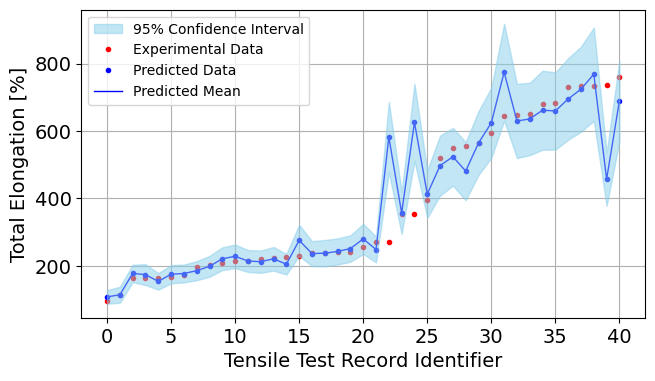

********************


100%|██████████| 3000/3000 [01:02<00:00, 47.75it/s, loss=3.074]  


Run # 1 Fold # 2
Pearson CC: 0.970455862792957
R2 score: 0.9382926299848704
RMSE: 56.84836959838867
MAE: 27.433876037597656
MAPE: 0.0
Coverage: 90.2439024390244
Median Interval Width: 79.96609497070312
Composite Metric: 0.6799555932694321


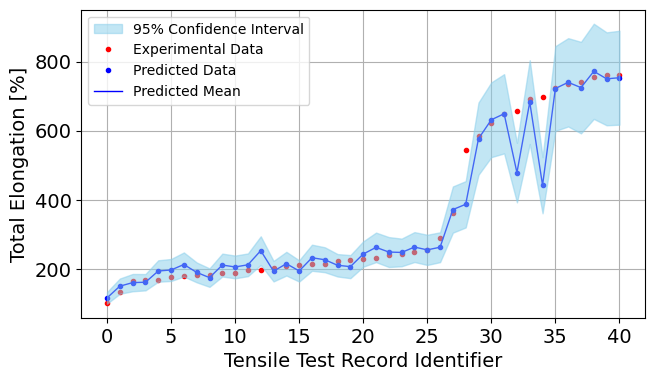

********************


100%|██████████| 3000/3000 [01:57<00:00, 25.57it/s, loss=15.023] 


Run # 1 Fold # 3
Pearson CC: 0.9479630695793932
R2 score: 0.8963162407480512
RMSE: 67.9522705078125
MAE: 36.25812911987305
MAPE: 0.0
Coverage: 75.60975609756098
Median Interval Width: 63.97674560546875
Composite Metric: 0.5709808405832139


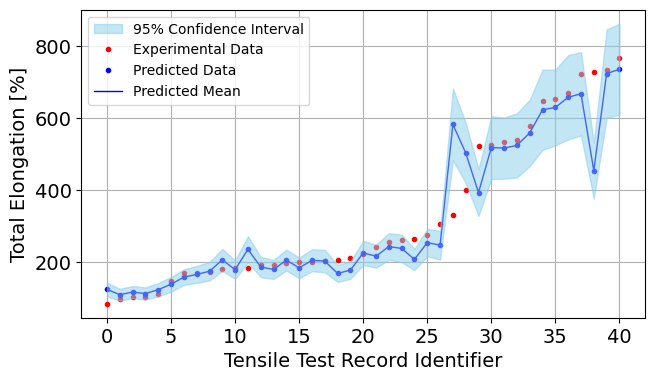

********************


100%|██████████| 3000/3000 [01:27<00:00, 34.28it/s, loss=16.097] 


Run # 1 Fold # 4
Pearson CC: 0.9660643723929192
R2 score: 0.9328885816636742
RMSE: 49.59239959716797
MAE: 27.488876342773438
MAPE: 0.0
Coverage: 80.48780487804878
Median Interval Width: 68.86093139648438
Composite Metric: 0.6072890422281164


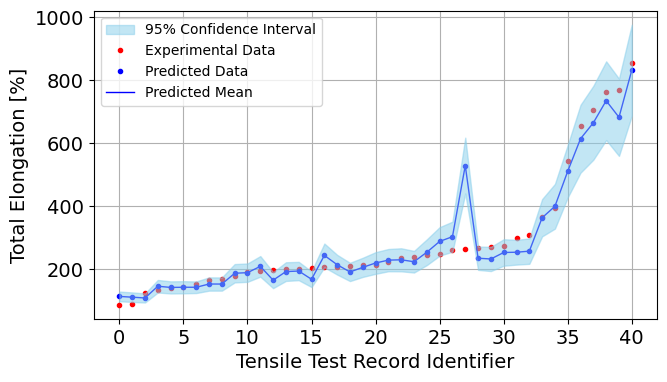

********************


100%|██████████| 3000/3000 [01:42<00:00, 29.41it/s, loss=12.476] 


Run # 1 Fold # 5
Pearson CC: 0.9756469603399528
R2 score: 0.9478348055755199
RMSE: 49.7389030456543
MAE: 23.793704986572266
MAPE: 0.0
Coverage: 90.0
Median Interval Width: 74.98365020751953
Composite Metric: 0.6783340601492208


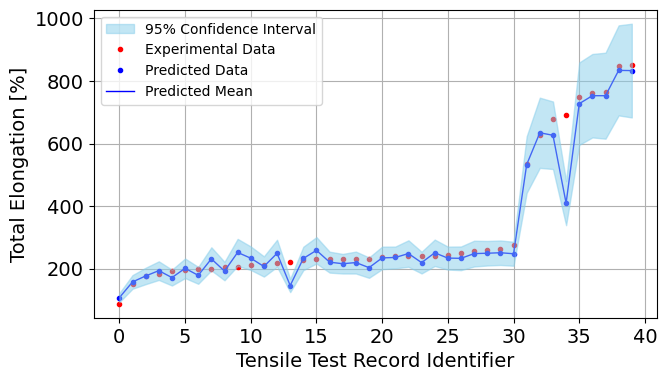

********************


In [19]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)

            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)

            train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)

            # define DNN
            class MLP(nn.Module):
                def __init__(self, input_dim=38, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
                    super().__init__()

                    self.use_dropout = use_dropout
                    if use_dropout:
                        self.dropout = nn.Dropout(p=0.5)
                    self.activation = nn.ReLU()

                    # dynamically define architecture
                    self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
                    layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                                range(1, len(self.layer_sizes))]
                    self.layers = nn.ModuleList(layer_list)

                def forward(self, input):
                    hidden = self.activation(self.layers[0](input))
                    for layer in self.layers[1:-1]:
                        hidden_temp = self.activation(layer(hidden))

                        if self.use_dropout:
                            hidden_temp = self.dropout(hidden_temp)

                        hidden = hidden_temp + hidden  # residual connection

                    output_mean = self.layers[-1](hidden).squeeze()
                    return output_mean

            def train(net, x_train, y_train):
                optimizer = torch.optim.Adagrad(params=net.parameters(), lr=0.01)
                criterion = nn.MSELoss()

                progress_bar = trange(3000)
                for _ in progress_bar:
                    for i, data in enumerate(train_dataloader):
                        traning_data, training_label = data
                        optimizer.zero_grad()
                        y_pred = net(torch.Tensor(traning_data))
                        loss = criterion(y_pred.squeeze(), torch.Tensor(training_label))
                        progress_bar.set_postfix(loss=f'{loss / features.shape[0]:.3f}')
                        loss.backward()
                        optimizer.step()
                return net

            # training
            net_dropout = MLP(hidden_dim=300, n_hidden_layers=3, use_dropout=True)
            net_dropout = train(net_dropout, x_train, y_train)

            print('Run #', j+1, "Fold #", i+1)

            # inference
            n_dropout_samples = 1000

            # compute predictions
            y_preds = [net_dropout(x_test).clone().detach().numpy() for _ in range(n_dropout_samples)]
            y_preds = np.array(y_preds)


            # Mean and standard deviation
            y_pred = np.mean(y_preds, axis=0)
            y_std = np.std(y_preds, axis=0)
            y_test = y_test.detach().numpy()

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'MAPE: {MAPE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='skyblue', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ro', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'bo', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="blue", label="Predicted Mean")
            ax[0].legend(fontsize=10, frameon=True, loc="upper left")
            ax[0].set_xlabel("Tensile Test Record Identifier", fontsize=14)
            ax[0].set_ylabel("Total Elongation [%]", fontsize=14)
            ax[0].tick_params(axis='both', which='major', labelsize=14)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.8')


            fig.delaxes(ax[1])
            plt.show()
            print(20*'*')

In [20]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.925343,0.852578,83.634628,39.749866,90.243902
1,0.970456,0.938293,56.848370,27.433876,90.243902
2,0.947963,0.896316,67.952271,36.258129,75.609756
3,0.966064,0.932889,49.592400,27.488876,80.487805
4,0.975647,0.947835,49.738903,23.793705,90.000000


In [21]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.957095,0.01841,0.913582,0.035146,61.553314,12.909774,30.944891,6.019449,85.317073,6.132388


In [22]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,90.243902,89.456787,0.679624
1,90.243902,79.966095,0.679956
2,75.609756,63.976746,0.570981
3,80.487805,68.860931,0.607289
4,90.000000,74.983650,0.678334


In [23]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)


test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
              },index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std
0,85.317073,6.132388,75.448842,8.852729
